<a href="https://colab.research.google.com/github/simulate111/Production-Optimization/blob/main/circlepacking_empty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

All installations must be done every time you re-open a notebook and want to run it. Google colab has many packages already installed, which you normally would need to install such as nympy, scipy , matplotlib, plotly, pandas. Most of these also comes with Anaconda (except plotly)

Adding text and code is done with "+ Code" or "+ Text" Sections can easlily be moved or deleted. To run a code you need to press the play buttom that appears when you move the cursor over a code block.

First we install pyomo (in quite mode). Since you will need to use
Runtime->Run all if you re-define a pyomo model, we add a try-except construction to the Python code to check if pyomo is already installed. The "!" allows us to run command (as in a terminal).

For this example we need the NLP solver ipopt. This is distributed with the larger package ideas (and now it seems that this solver should be called as ipopt_l1, this may change again).

In [11]:
#Install pyomo and solvers from the IDAES project
#this installs several solvers like ipopt, cbc, bonmin but takes some time to run
#ipopt is now under the name ipop_l1
try:
  not_first_time == True
except:
  !pip install idaes-pse --pre
  !idaes get-extensions --to ./bin
  not_first_time = True
finally:
  print("Pyomo and solvers installed")


Pyomo and solvers installed


The problem in compact form:

$ \min \: w \cdot h$

s.t

$x_c \ge r_c \:\: \forall c \in C$

$x_c + r_c \le w \:\: \forall c \in C$

$y_c \ge r_c \:\: \forall c \in C$

$y_c + r_c \le h \:\: \forall c \in C$

$(x_c-x_{c^\prime})^2+(y_c-y_{c^\prime})^2 \ge (r_c+r_{c^\prime})^2 \:\: \forall c,c^{\prime} \in C,c \lt c^{\prime}$

$h,w,x_c,y_c \in \mathbb{R}_{\ge 0}, C=\{c_1,c_2,c_3,c_4\}$



The radius of the circles, from 1 to 4, are 3, 3, 2 and 3, respectively.

When you are done with the this problem, add a cicle with your name and a radius

In [12]:
from pyomo.environ import *
import matplotlib.pyplot as plt
#return this cell if you make changes

m=ConcreteModel()

#Sets Set(initialize=,doc='')
m.C = Set(initialize=['c1', 'c2', 'c3', 'c4'], doc='Circles')

#Parameters Param(initialize={key:values},doc='')
radii_data = {'c1': 3, 'c2': 3, 'c3': 2, 'c4': 3}
m.r = Param(m.C, initialize=radii_data, doc='Radius of circle')

#Variables Var(within=NonNegativeReals,doc='') (Starting guesses can be given with initialize={key:values}, usually no need)
m.w = Var(within=NonNegativeReals, initialize=20.0, doc='Width of the bounding box')
m.h = Var(within=NonNegativeReals, initialize=20.0, doc='Height of the bounding box')

def x_init_rule(m, c):
    # Initial x-coordinate for each circle center at its minimum allowed value
    return m.r[c]

def y_init_rule(m, c):
    # Initial y-coordinate for each circle center at its minimum allowed value
    return m.r[c]

m.x = Var(m.C, within=NonNegativeReals, initialize=x_init_rule, doc='x-coordinate of circle center')
m.y = Var(m.C, within=NonNegativeReals, initialize=y_init_rule, doc='y-coordinate of circle center')

#Objective Objective(expr= , sense=minimize, doc='')
m.obj = Objective(expr=m.w * m.h, sense=minimize, doc='Minimize Area')

#Constraints Constraint(rule= ,doc='')
# Boundary constraints
m.x_lower = Constraint(m.C, rule=lambda m, c: m.x[c] >= m.r[c])
m.x_upper = Constraint(m.C, rule=lambda m, c: m.x[c] + m.r[c] <= m.w)
m.y_lower = Constraint(m.C, rule=lambda m, c: m.y[c] >= m.r[c])
m.y_upper = Constraint(m.C, rule=lambda m, c: m.y[c] + m.r[c] <= m.h)

# Non-overlap constraint
def non_overlap_rule(m, c1, c2):
    # Ensure each pair is considered only once and avoid self-comparison
    if c1 < c2:
        return (m.x[c1] - m.x[c2])**2 + (m.y[c1] - m.y[c2])**2 >= (m.r[c1] + m.r[c2])**2
    return Constraint.Skip

m.non_overlap = Constraint(m.C, m.C, rule=non_overlap_rule)

m.pprint()

1 Set Declarations
    C : Circles
        Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    4 : {'c1', 'c2', 'c3', 'c4'}

1 Param Declarations
    r : Radius of circle
        Size=4, Index=C, Domain=Any, Default=None, Mutable=False
        Key : Value
         c1 :     3
         c2 :     3
         c3 :     2
         c4 :     3

4 Var Declarations
    h : Height of the bounding box
        Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  20.0 :  None : False : False : NonNegativeReals
    w : Width of the bounding box
        Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  20.0 :  None : False : False : NonNegativeReals
    x : x-coordinate of circle center
        Size=4, Index=C
        Key : Lower : Value : Upper : Fixed : Stale : Domain
         c1 :     0 :     3 :  None : False : False : NonNegat

In [13]:
#Solve in a separate stage, since we need to build the model first. When ready, one cell would do.
#added path to the executable, seems to be necessary
solver = SolverFactory("ipopt_l1",executable="/content/bin/ipopt_l1") #it used to be ipopt...

#solver = SolverFactory("couenne",executable="/content/bin/couenne") #this may take forever with large problems, restrict time using a opt-file
#with open("couenne.opt","w") as file:
#    file.write("time_limit 30")

results = solver.solve(m, keepfiles=False, tee=True)
#m.display()

Ipopt 3.13.3: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

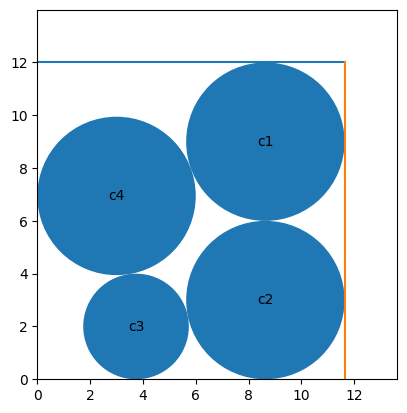

In [14]:
#Code for plotting the solution
figure, axes = plt.subplots()
for c in m.C:
    draw_circle = plt.Circle((m.x[c].value, m.y[c].value),m.r[c] )
    axes.add_artist(draw_circle)
    axes.text(m.x[c].value, m.y[c].value, c,
         horizontalalignment='center', verticalalignment='center')

plt.plot([0, m.w.value],[m.h.value, m.h.value])
plt.plot([m.w.value,m.w.value],[0, m.h.value])
axes.set_aspect(1)

plt.xlim(0,m.w.value+2)
plt.ylim(0,m.h.value+2)
plt.show()

In [15]:
#Importing using Pandas dataframes from Excel is practical. For a simple Excel file with headers in the first row and data i cells below this works
#(there are many ways to do the same thing)

#import pandas as pd
#
#df = pd.read_excel('circle_data.xlsx') #you need to upload the file to colab each session
#m.C = Set(initialize=df.set_index('circles').index.to_list(),doc='Circles')
#m.r = Param(m.C,initialize=df.set_index('circles')['radius'].to_dict(),doc='Radius of circle')



In [16]:
#something on dataframes

#df2=df.set_index('circles') #creates a new dataframe that has circles as indices
#df2['radius'] #getting the elements in the column 'radius' as a series
#df2['radies'].to_dict() #convert the series to a dictionary
#df.set_index('circles')['radius'].to_dict() #everything in one step